In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from dashboard_app._format_utils import format_price_short, format_number_short
from dashboard_app._chart_utils import chart_colors, get_chart_color

# Define custom color palette
# colors = ["#6C969D", "#97CC04", "#2D7DD2", "#EEB902", "#474647", "#F45D01", "#9B6B6C", "#556F44"]
# custom_cmap = LinearSegmentedColormap.from_list("custom", colors)

# Set global figure size and DPI
# Set figure size optimized for A4 (297mm x 210mm at 300dpi)
plt.rcParams['figure.figsize'] = (10, 7)  # Adjusted for better A4 fit
plt.rcParams['figure.dpi'] = 300

# Configure fonts
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11  # Base font size
plt.rcParams['font.weight'] = 'normal'

# grid lines subtle thin
plt.rcParams['grid.color'] = '#d9d9d9'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5

# spines light gray thin
plt.rcParams['axes.edgecolor'] = '#d9d9d9'
plt.rcParams['axes.linewidth'] = 0.5


# Function to format event datetime
def format_event_datetime(dt, include_time=True):
	"""Format datetime to event-relative format (Day 1, Day 2, Day 3)"""
	if isinstance(dt, str):
		dt = pd.to_datetime(dt)

	event_days = {
		pd.Timestamp('2024-07-04').date(): 'Day 1',
		pd.Timestamp('2024-07-05').date(): 'Day 2',
		pd.Timestamp('2024-07-06').date(): 'Day 3'
	}

	date_only = dt.date()
	day_label = event_days.get(date_only, 'Day 1')  # Default to Day 1 instead of Unknown Day

	if include_time:
		return f"{day_label} {dt.strftime('%H:00')}"  # Changed to show only hour
	return day_label


# Function to load data from CSV or DataFrame
def load_data(data_source):
	if isinstance(data_source, str):
		# Load data from CSV file
		data = pd.read_csv(f"./thesis/results/{data_source}")
	else:
		# Assume data_source is a DataFrame
		data = data_source
	return data


# Function to create subplots with consistent formatting
def create_subplots(nrows=1, ncols=1, figsize=(10, 6), sharex=False, sharey=False):
	fig, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=sharex, sharey=sharey)

	if nrows * ncols > 1:
		for ax in axes.flat:
			ax.tick_params(axis='both', which='major', labelsize=10)
			ax.tick_params(axis='both', which='minor', labelsize=8)
	else:
		axes.tick_params(axis='both', which='major', labelsize=10)
		axes.tick_params(axis='both', which='minor', labelsize=8)

	return fig, axes


# Function to format x-labels as event datetime
def format_xaxis_event_datetime(ax, include_time=True):
	ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: format_event_datetime(pd.to_datetime(x), include_time)))
	plt.xticks(rotation=45, ha='right')


# Function to add reference line to plot
def add_reference_line(ax, x=None, y=None, color='gray', linestyle='--', linewidth=1, label=None):
	if x is not None:
		ax.axvline(x, color=color, linestyle=linestyle, linewidth=linewidth, label=label)
	elif y is not None:
		ax.axhline(y, color=color, linestyle=linestyle, linewidth=linewidth, label=label)


# Function to save chart with consistent formatting
def save_chart(p, filename, dpi=300, bbox_inches='tight', pad_inches=0.1):
	p.savefig(f"./thesis/results/{filename}", dpi=dpi, bbox_inches=bbox_inches, pad_inches=pad_inches)

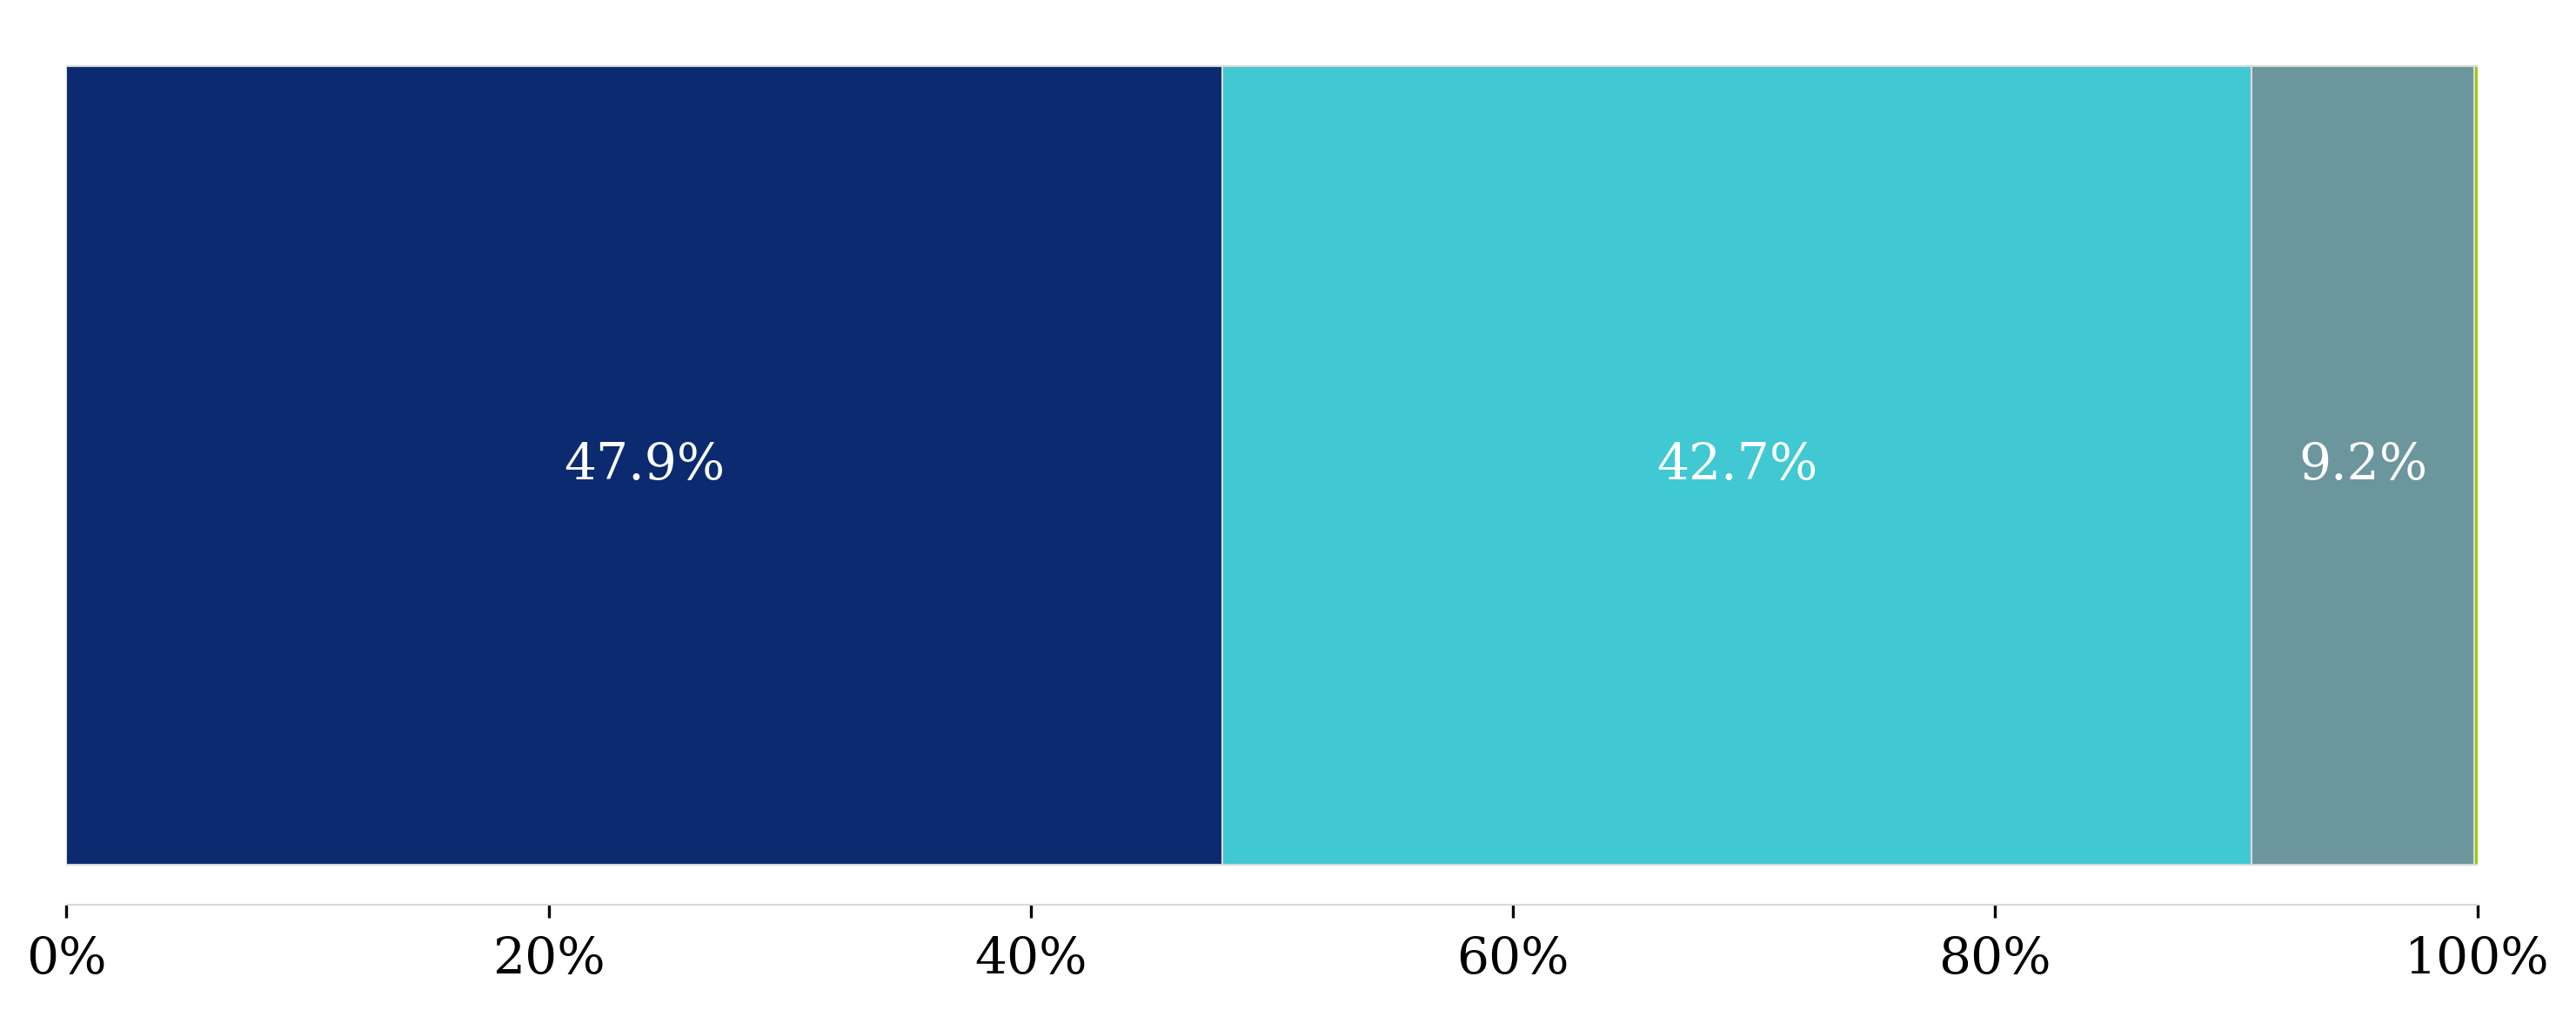

In [6]:
# Data from the pie chart
data = {
	"Payment Method": ["Card terminal", "Cash", "Online pre top-up", "VIP issued"],
	"Count": [8486, 7561, 1634, 23],
	"Total Value (CZK)": [7264503, 5782570, 1436400, 37500]
}

# Convert data to a DataFrame
df = pd.DataFrame(data)

# Calculate proportions for the 100% stacked bar chart
df["Proportion"] = df["Count"] / df["Count"].sum()

# Define a minimum proportion for visibility
min_proportion = 0.02  # Set minimum visual width (2%)
df["Visual Proportion"] = df["Proportion"].apply(lambda x: max(x, min_proportion))

# Prepare data for plotting
methods = df["Payment Method"]
proportions = df["Proportion"]
visual_proportions = df["Visual Proportion"]
total_values = df["Total Value (CZK)"]

# Create a subplot
fig, ax = create_subplots(figsize=(10, 4))  # Wider figure for a horizontal bar

# Plot the horizontal 100% stacked bar chart
left = 0
for i, (proportion, visual_proportion, method, value, color) in enumerate(
		zip(proportions, visual_proportions, methods, total_values, chart_colors[:len(methods)])
):
	ax.barh(
		y=0,
		width=visual_proportion,
		left=left,
		color=color,
		edgecolor="#d9d9d9",
		linewidth=0.5,
		label=method
	)
	# Add proportion and value label inside or outside based on size
	label_text = f"{proportion * 100:.1f}%"
	if visual_proportion < 0.03:  # If the segment is small, place the label outside
		continue
	else:
		ax.text(
			left + visual_proportion / 2,
			0,
			label_text,
			ha='center',
			va='center',
			color='white',
			fontsize=14,
		)
	left += visual_proportion

# Customize the axes
ax.set_xlim(0, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])  # Remove y-ticks as it is a single bar
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x * 100)}%"))
# x-ticks fontsize=14, pad=5
ax.tick_params(axis='x', which='major', labelsize=14, pad=5)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=10, frameon=False)

plt.tight_layout()
# plt.show()
plt.savefig("./thesis/results/rq2-topup-methods.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

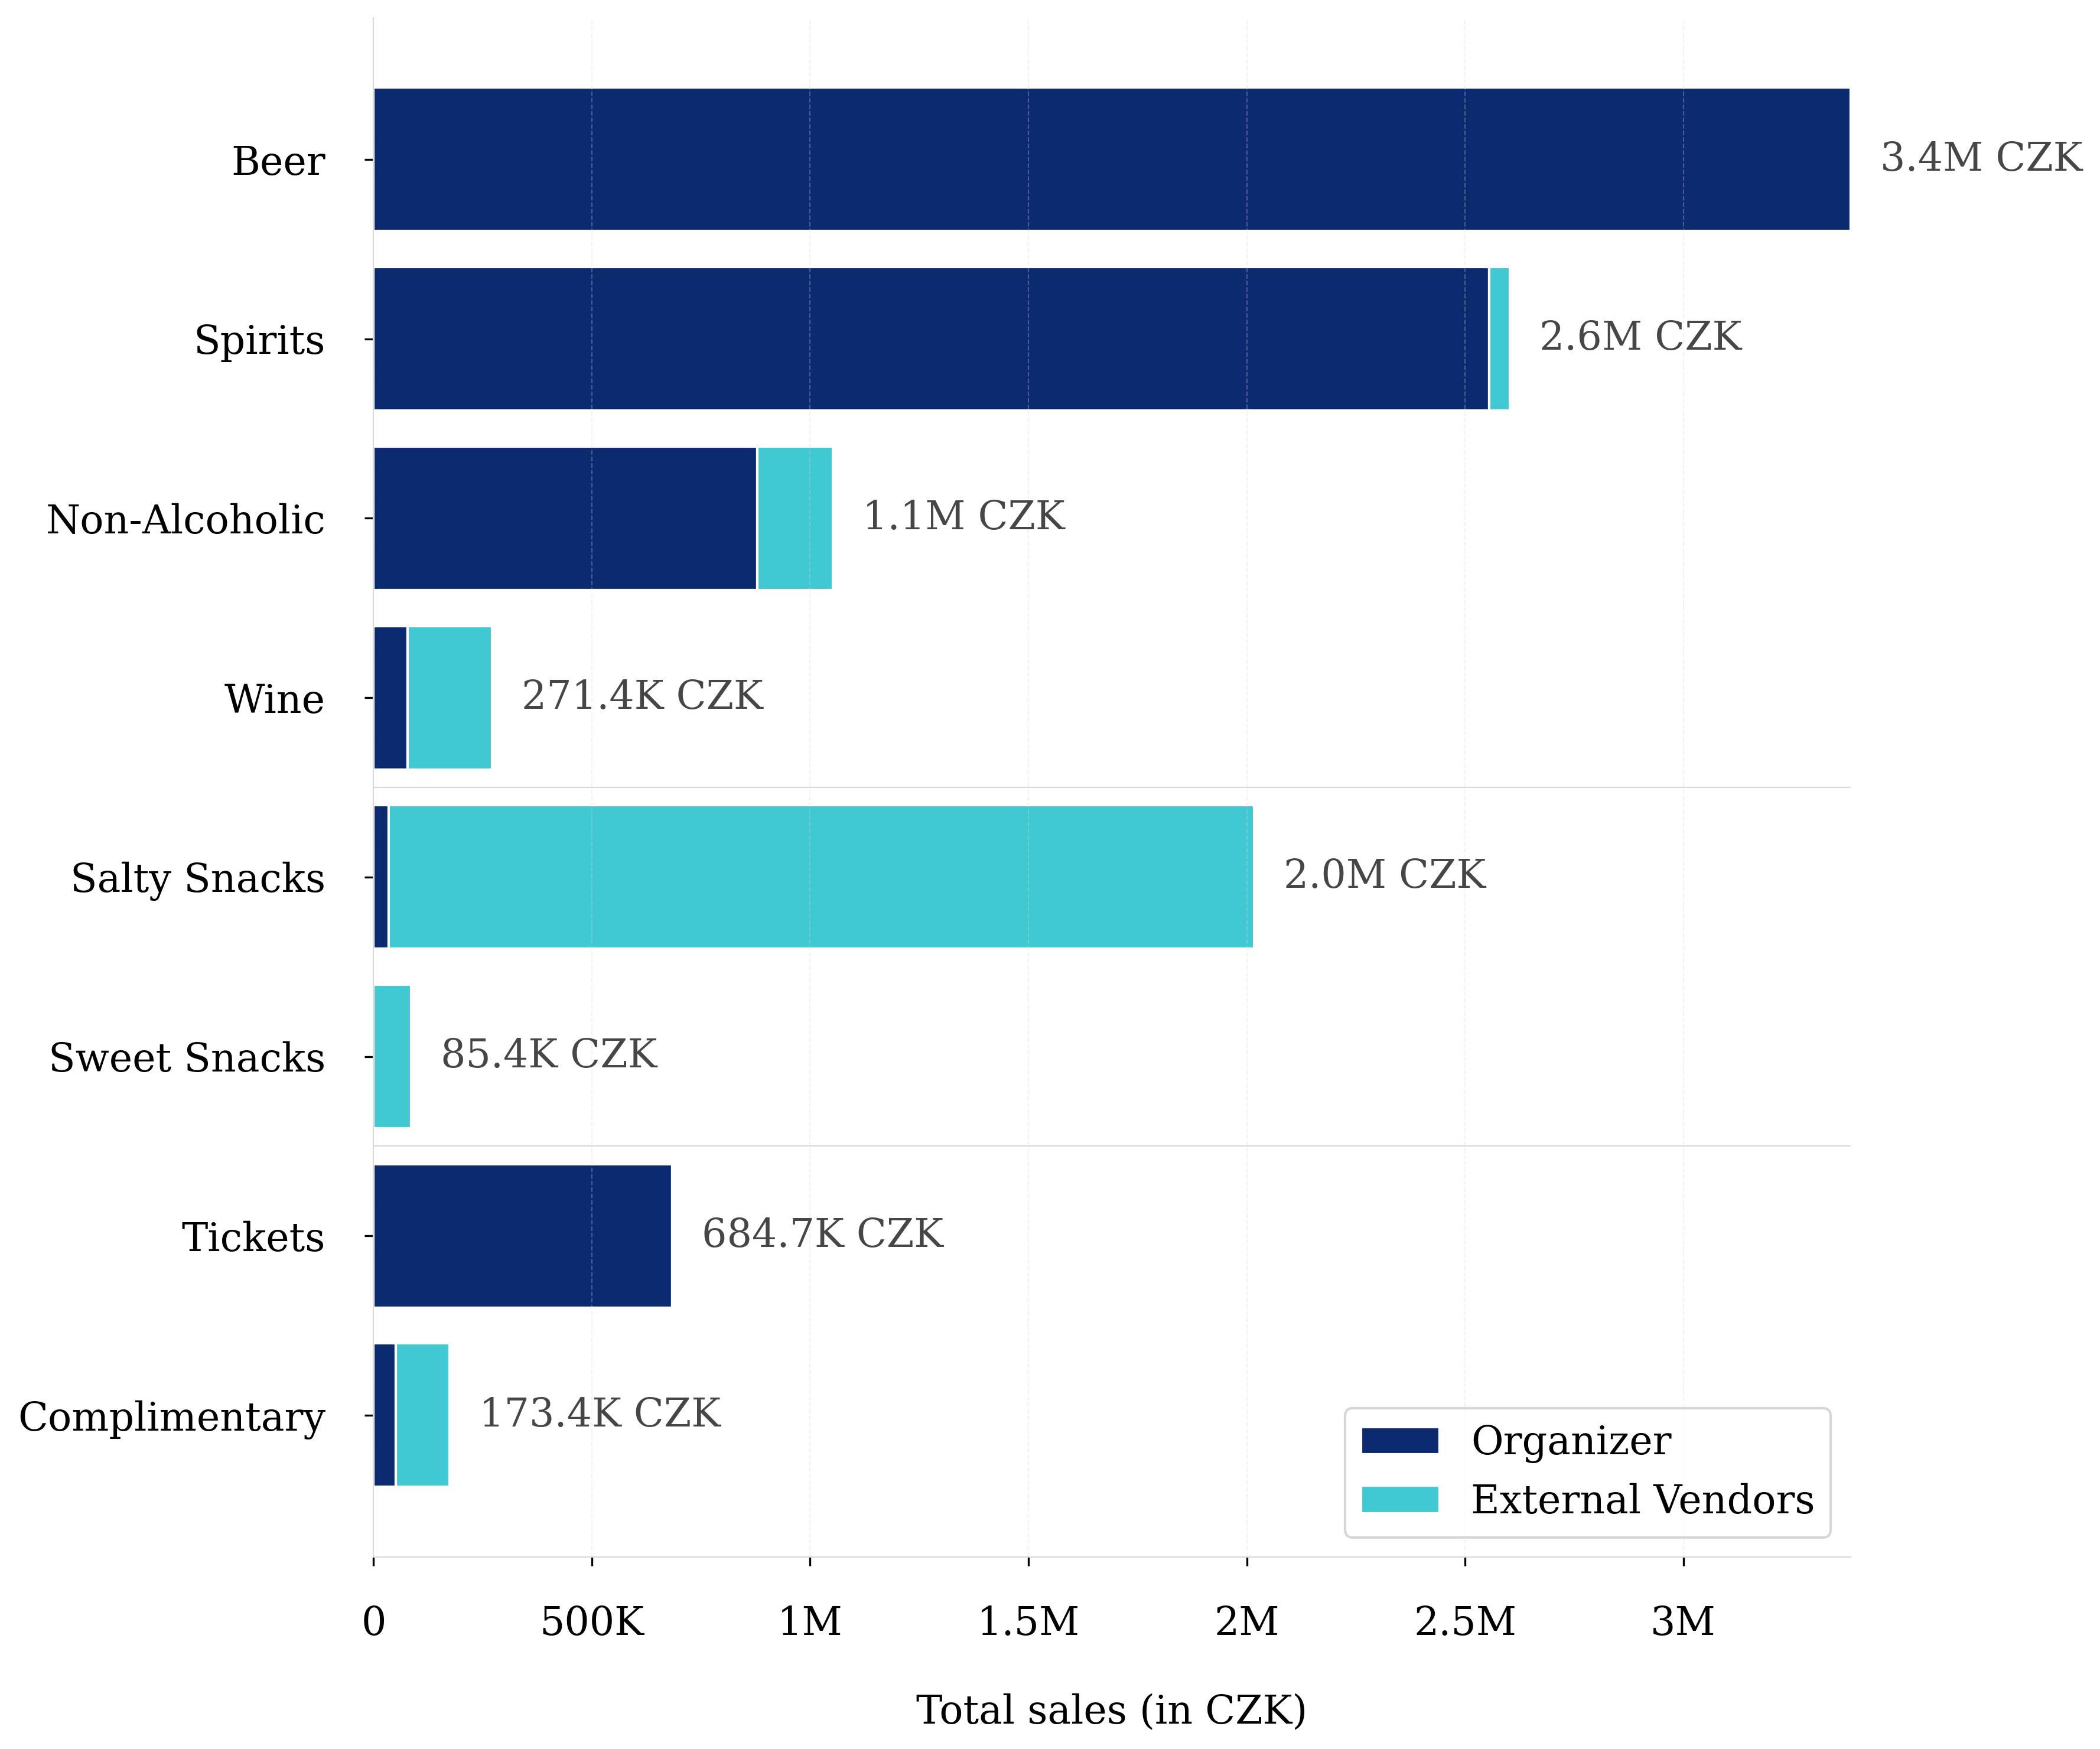

In [7]:
import matplotlib.pyplot as plt

data = load_data("rq4-organizer-vs-vendor-sales.csv")

# Define category order and grouping (reversed for bottom-to-top display)
category_order = [
	'complimentary', 'ticket',  # Other
	'sweet', 'salty',  # Food
	'wine', 'non_alcoholic', 'spirits', 'beer'  # Beverages
]

category_labels = {
	"beer": "Beer",
	"spirits": "Spirits",
	"non_alcoholic": "Non-Alcoholic",
	"wine": "Wine",
	"salty": "Salty Snacks",
	"sweet": "Sweet Snacks",
	"ticket": "Tickets",
	"complimentary": "Complimentary"
}

# Prepare data
organizer_values = data.loc[data['source'] == 'organizer', category_order].iloc[0]
external_values = data.loc[data['source'] == 'external', category_order].iloc[0]
total_values = organizer_values + external_values

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot bars
y_positions = range(len(category_order))
bars_organizer = ax.barh(
	y_positions, organizer_values,
	label="Organizer",
	color=get_chart_color(0),
	edgecolor='white'
)
bars_external = ax.barh(
	y_positions, external_values, left=organizer_values,
	label="External Vendors",
	color=get_chart_color(1),
	edgecolor='white'
)

# Add category labels
ax.set_yticks(y_positions)
ax.set_yticklabels([category_labels[cat] for cat in category_order], fontsize=16)
# y-ticks fontsize=16, pad=5
ax.tick_params(axis='y', which='major', labelsize=16, pad=16)

# Add value and percentage labels
for i, (org_val, ext_val) in enumerate(zip(organizer_values, external_values)):
	total = org_val + ext_val

	# Add total value
	ax.text(
		total + (max(total_values) * 0.02), i,
		format_price_short(total),
		va='center', ha='left', fontsize=16, color='#474647'
	)

# Add gridlines
ax.grid(axis='x', linestyle='--', alpha=0.3, zorder=-1)

# Add group separators
group_separators = [1.5, 3.5]  # Adjusted positions for reversed order
for sep in group_separators:
	ax.axhline(y=sep, color='#d9d9d9', linestyle='-', linewidth=0.5)

# Customize chart
ax.set_xlabel("Total sales (in CZK)", fontsize=16, labelpad=20)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: format_number_short(x / 100)))
# x-ticks fontsize=16, pad=10
ax.tick_params(axis='x', which='major', labelsize=16, pad=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=16, loc="lower right")

# Add group labels with adjusted positions
# ax.text(
# 	-max(total_values) * 0.15, 6.5, "Beverages", rotation=90,
# 	va='center', ha='center', fontsize=10, color='#474647'
# )
# ax.text(
# 	-max(total_values) * 0.15, 2.5, "Food", rotation=90,
# 	va='center', ha='center', fontsize=10, color='#474647'
# )
# ax.text(
# 	-max(total_values) * 0.15, 0.5, "Other", rotation=90,
# 	va='center', ha='center', fontsize=10, color='#474647'
# )

plt.tight_layout()
plt.savefig("./thesis/results/rq4-organizer-vs-vendor-sales.png", dpi=300, bbox_inches='tight', pad_inches=0.1)



In [8]:
import plotly.graph_objects as go
from dashboard_app._chart_utils import SankeyDiagram


def format_value(value, show_percentage=False, total=None, group_total=None):
	"""Format values with simplified formatting to match thesis"""
	if value >= 1_000_000:
		val_str = f'{value / 1_000_000:.1f}M CZK'
	elif value >= 1_000:
		val_str = f'{value / 1_000:.1f}K CZK'
	else:
		val_str = f'{value:.0f} CZK'

	if show_percentage:
		percentage = value / (total or group_total) * 100
		val_str = f'{val_str} ({percentage:.1f}%)'

	return val_str


# Create Sankey diagram
sankey = SankeyDiagram()

# Data preparation
remaining_amount = 3536028
refunded_amount = 3178946
non_refundable = 22651
unclaimed = 334431

# Add nodes (x,y will be overridden later)
sankey.add_node(
	'remaining',
	f'Remaining Credit {format_value(remaining_amount)}',
	0, 0, 'slate_blue'
)

sankey.add_node(
	'refunded',
	f'Refunded {format_value(refunded_amount, True, remaining_amount)}',
	0, 0, 'sage'
)

sankey.add_node(
	'non_refundable',
	f'Non-refundable {format_value(non_refundable, True, remaining_amount)}',
	0, 0, 'peach'
)

sankey.add_node(
	'unclaimed',
	f'Unclaimed {format_value(unclaimed, True, remaining_amount)}',
	0, 0, 'mint'
)

sankey.add_node(
	'bank',
	f'Bank Refunds {format_value(3163567, True, group_total=refunded_amount)}',
	0, 0, 'sage'
)

sankey.add_node(
	'pos',
	f'On-site Refunds {format_value(15379, True, group_total=refunded_amount)}',
	0, 0, 'sage'
)

sankey.add_node(
	'vip',
	f'VIP Credit {format_value(12405, True, group_total=non_refundable)}',
	0, 0, 'peach'
)

sankey.add_node(
	'integrity',
	f'Integrity Errors {format_value(10246, True, group_total=non_refundable)}',
	0, 0, 'peach'
)

# Add flows
sankey.add_flow('remaining', 'refunded', refunded_amount, 'slate_blue')
sankey.add_flow('remaining', 'non_refundable', non_refundable, 'slate_blue')
sankey.add_flow('remaining', 'unclaimed', unclaimed, 'slate_blue')

sankey.add_flow('refunded', 'bank', 3163567, 'sage')
sankey.add_flow('refunded', 'pos', 15379, 'sage')
sankey.add_flow('non_refundable', 'vip', 12405, 'peach')
sankey.add_flow('non_refundable', 'integrity', 10246, 'peach')

# Get the plotly dict and override positioning
plotly_dict = sankey.to_plotly()
node_dict = plotly_dict['node']

# Exact positioning to match thesis
node_dict.update(
	{
		'x': [0.1,  # Remaining Credit
		      0.5,  # Refunded
		      0.5,  # Non-refundable
		      0.5,  # Unclaimed
		      0.9,  # Bank Refunds
		      0.9,  # On-site Refunds
		      0.9,  # VIP Credit
		      0.9],  # Integrity Errors
		'y': [0.5,  # Remaining Credit
		      0.75,  # Refunded
		      0.25,  # Non-refundable
		      0.5,  # Unclaimed
		      0.8,  # Bank Refunds
		      0.7,  # On-site Refunds
		      0.3,  # VIP Credit
		      0.2],  # Integrity Errors
		'pad': 50,  # Reduced padding for better flow
		'thickness': 30,  # Adjusted thickness
	}
)

# Create figure with explicit positioning
fig = go.Figure(
	data=[go.Sankey(
		arrangement="snap",
		node=node_dict,
		link=plotly_dict['link'],
		textfont={ "size": 32 }  # Ensure consistent text size
	)]
)

# # Add background colors for stages
# fig.add_shape(
# 	type="rect",
# 	x0=0, x1=0.45,
# 	y0=0, y1=1,
# 	fillcolor="rgba(240, 240, 255, 0.5)",
# 	line=dict(width=0),
# 	layer="below"
# )
#
# fig.add_shape(
# 	type="rect",
# 	x0=0.55, x1=1,
# 	y0=0, y1=1,
# 	fillcolor="rgba(240, 255, 240, 0.5)",
# 	line=dict(width=0),
# 	layer="below"
# )

# Update layout
fig.update_layout(
	font=dict(family='serif', size=32),
	paper_bgcolor='white',
	plot_bgcolor='white',
	width=2400,
	height=1500,
	margin=dict(t=50, l=25, r=25, b=200),
	annotations=[
		dict(
			x=0.25,
			y=0.98,
			xref='paper',
			yref='paper',
			text='Stage 1: Initial Distribution',
			showarrow=False,
			font=dict(size=36, family='serif'),
			align='center'
		),
		dict(
			x=0.75,
			y=0.98,
			xref='paper',
			yref='paper',
			text='Stage 2: Final Allocation',
			showarrow=False,
			font=dict(size=36, family='serif'),
			align='center'
		),
		# Centered note
		dict(
			x=0.5,
			y=-0.15,
			xref='paper',
			yref='paper',
			text='Note: Percentages in groups are relative to Remaining Credit,<br>while percentages in detail nodes are relative to their respective group totals',
			showarrow=False,
			font=dict(size=36, family='serif'),
			align='center'
		)
	]
)

# Save with high quality
fig.write_image("credit_flow_thesis.pdf", scale=4)
fig.write_image("credit_flow_thesis.png", scale=4, width=2400, height=1400)
fig.write_html("credit_flow_thesis.html")

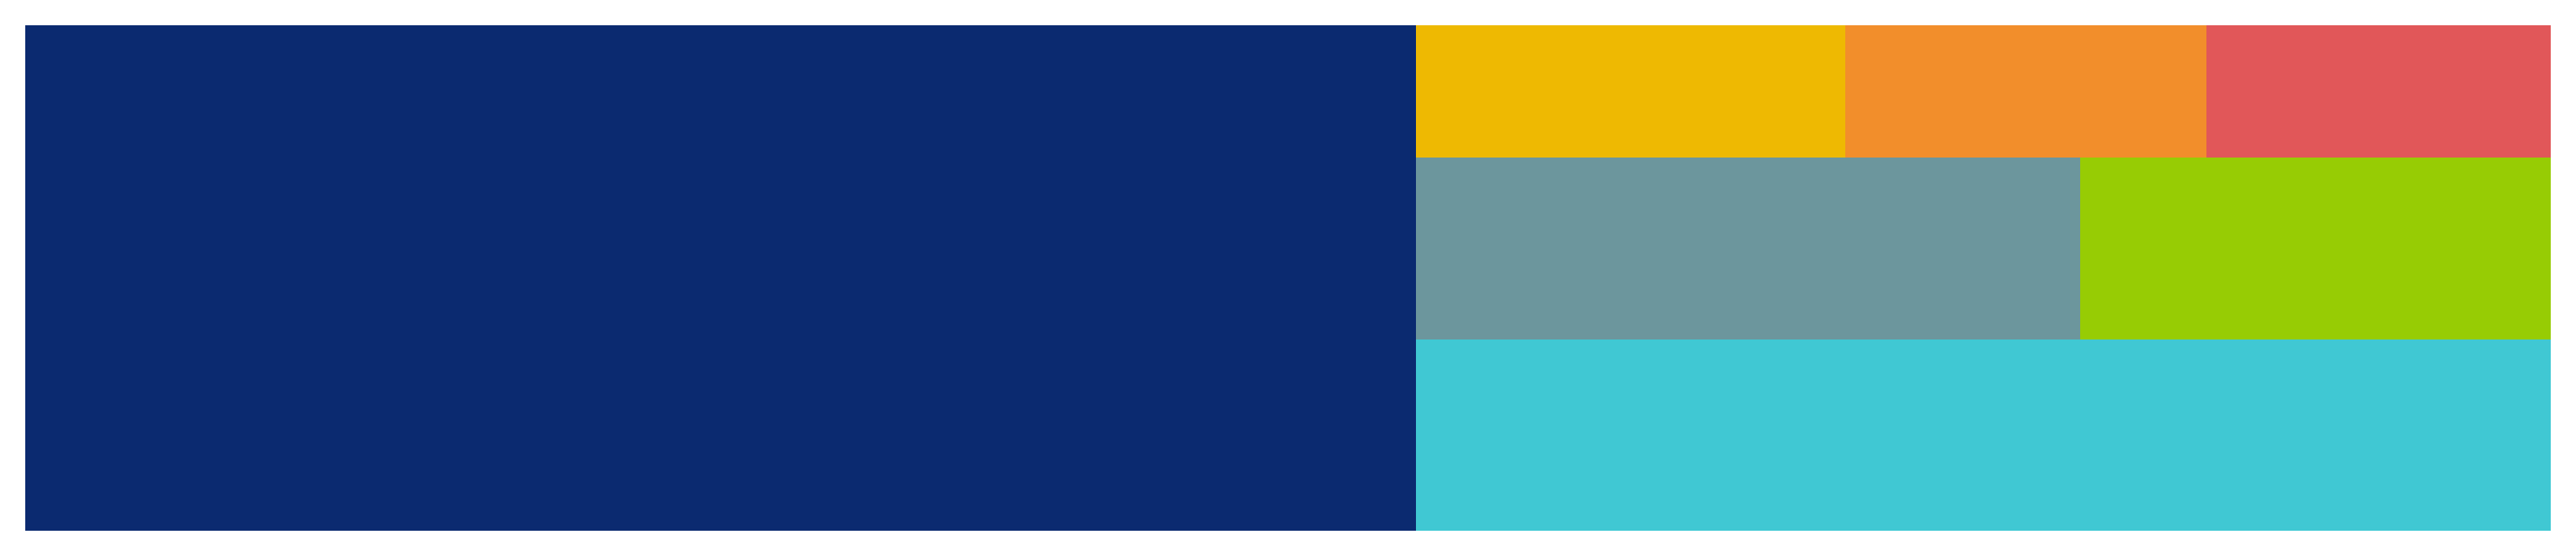

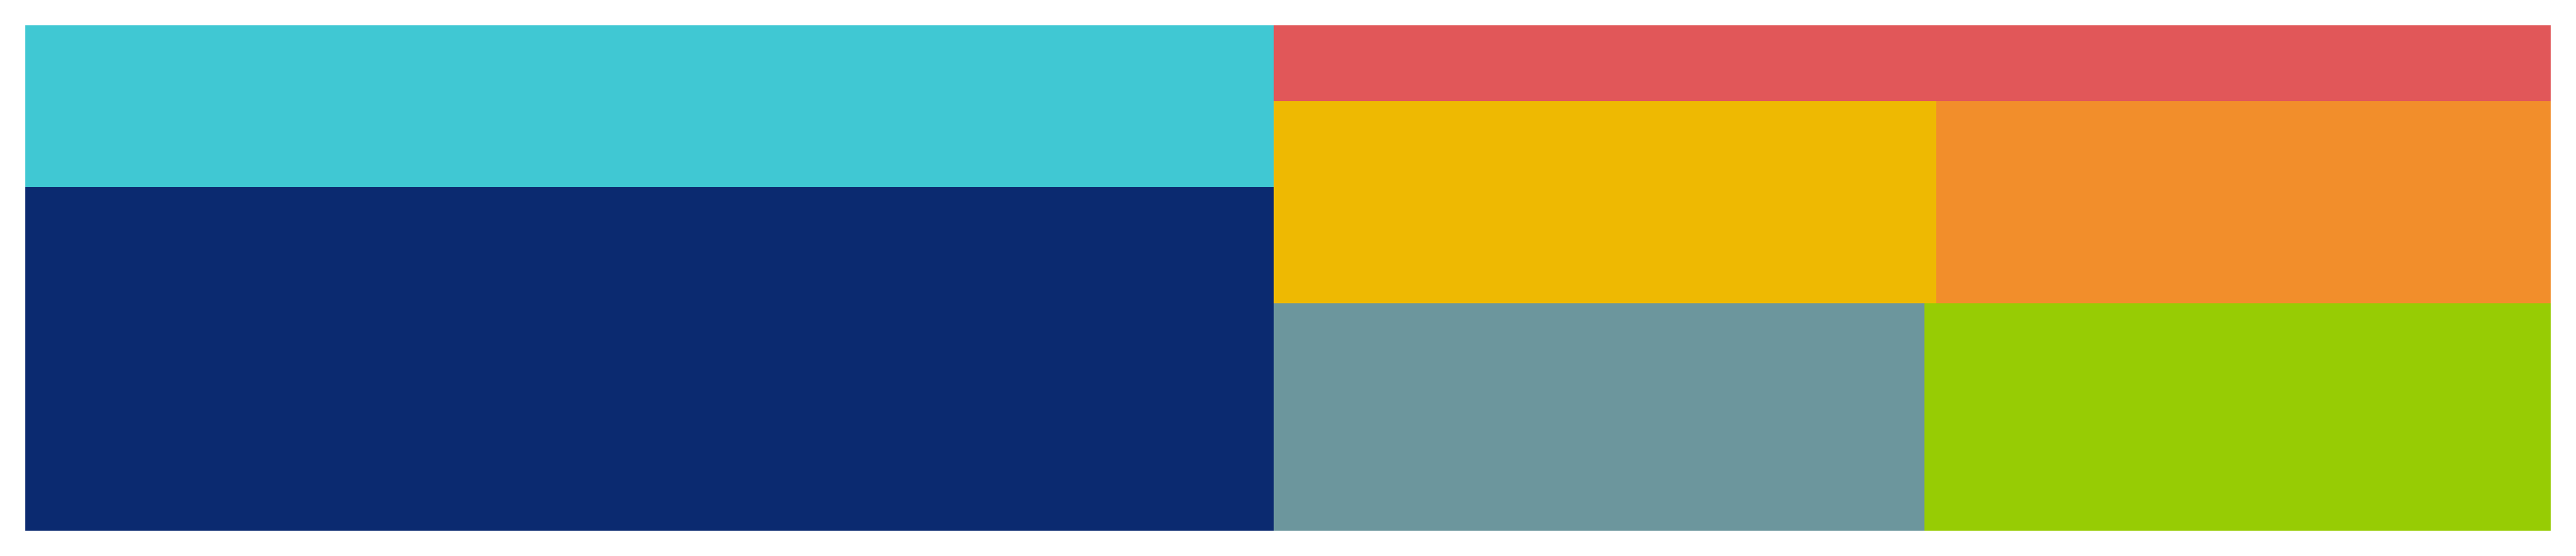

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify  # For treemap visualization

# Load data using your function
data_non = load_data("rq26-product-combos-nonreturnable.csv")
data_with = load_data("rq26-product-combos-with-returnable.csv")


def treemap_combos(data):
	# Select top 10 product combinations
	top_combinations = data.nlargest(7, 'combination_count')

	# Prepare the data for the treemap
	sizes = top_combinations['combination_count']

	# Use custom colors for the treemap
	colors = [
		get_chart_color(i) for i in range(len(sizes))
	]

	# Create the treemap
	plt.figure(figsize=(10, 2))
	squarify.plot(sizes=sizes, color=colors, bar_kwargs=dict(linewidth=0))

	# Remove labels
	plt.axis('off')
	plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
	return plt


# Show the treemap
plt1 = treemap_combos(data_non)
plt1.savefig("./thesis/results/rq26-product-combos-nonreturnable.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt2 = treemap_combos(data_with)
plt2.savefig("./thesis/results/rq26-product-combos-with-returnable.png", dpi=300, bbox_inches='tight', pad_inches=0)

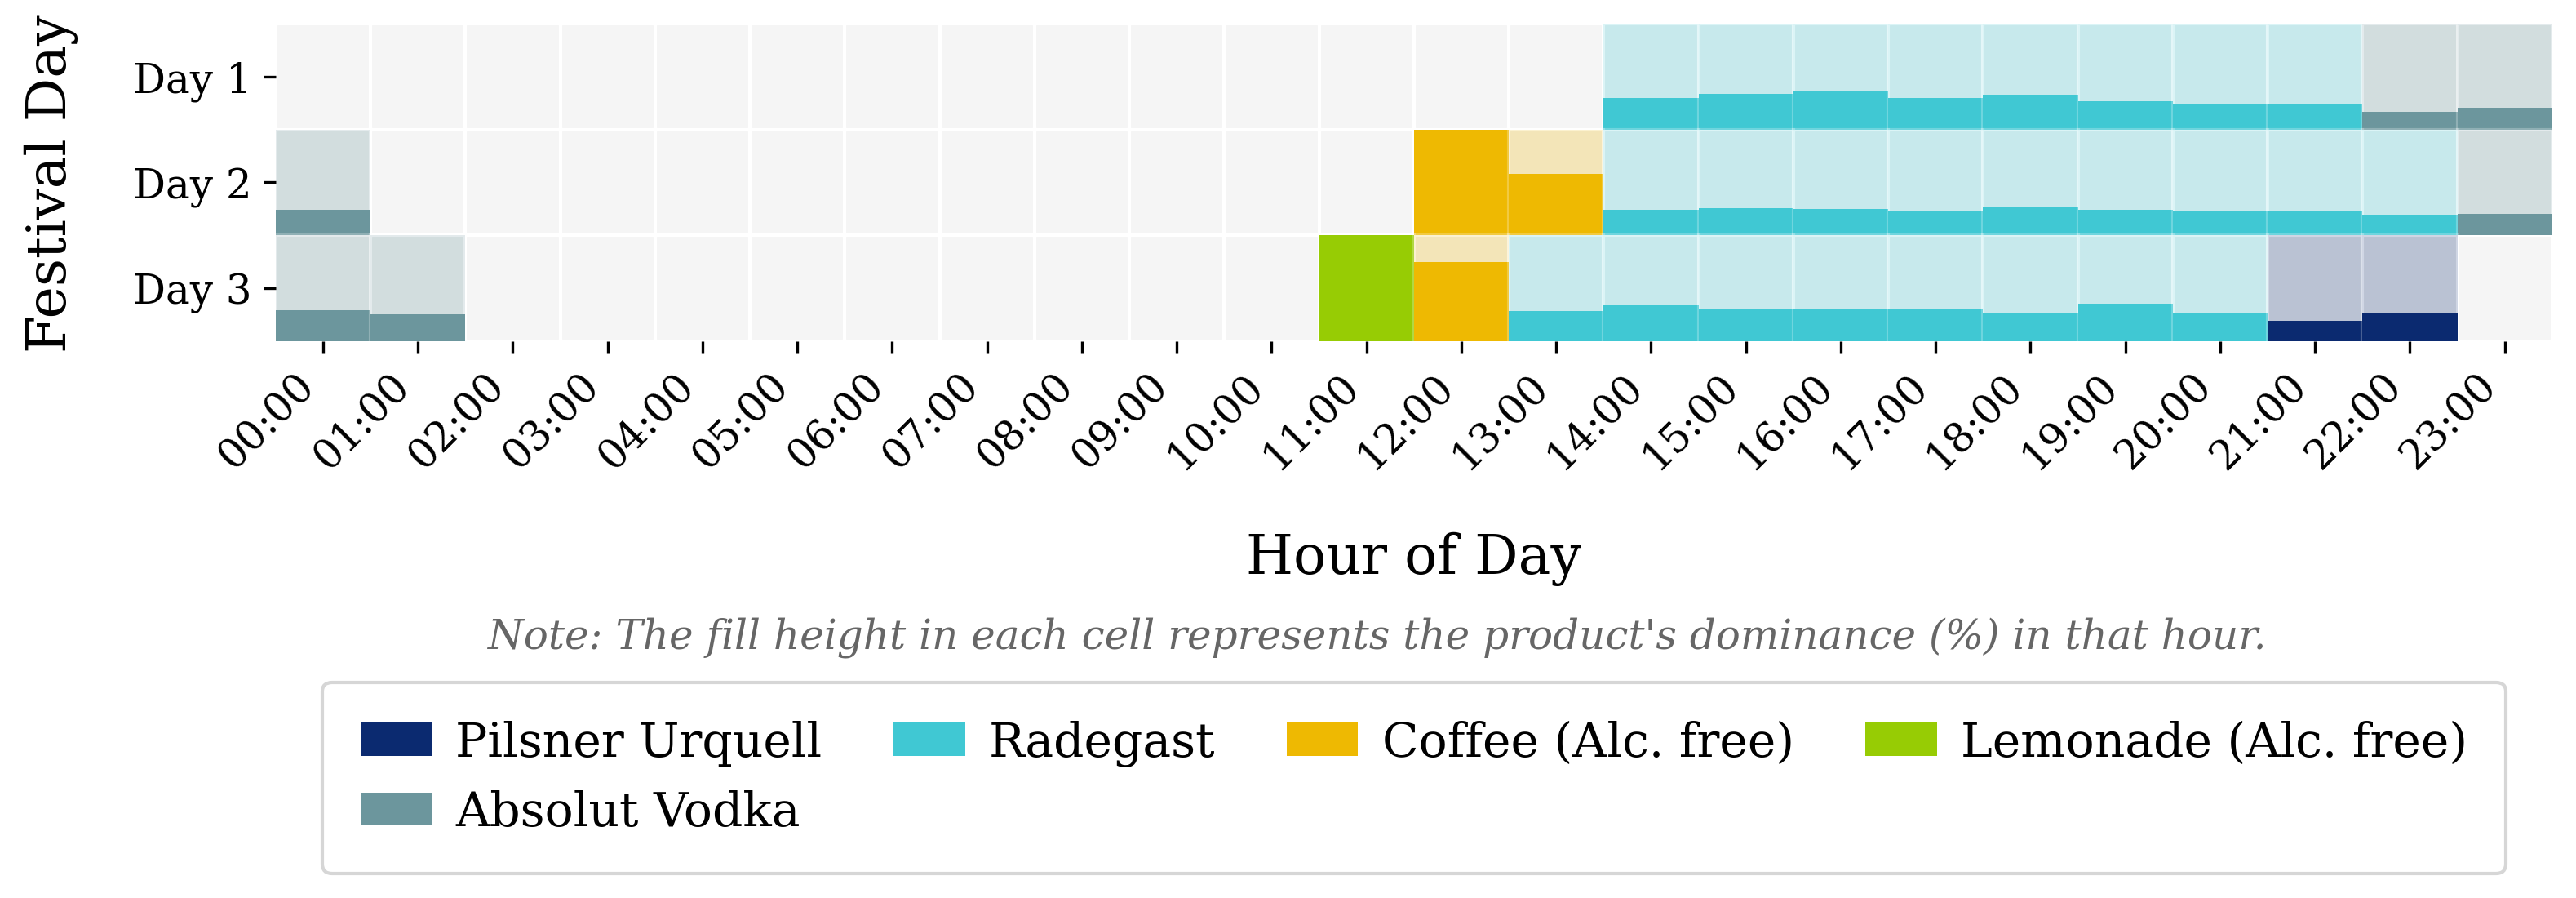

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec

# Load and prepare data
df = load_data("rq25-beverage-prefs.csv")
df['datetime'] = pd.to_datetime(df['hour'])
df['day'] = df['datetime'].apply(lambda x: format_event_datetime(x, include_time=False))
df['hour_num'] = df['datetime'].dt.hour

# Color scheme
colors = {
	# 'Radegast': '#97AA84',
	# 'Pilsner Urquell': '#355935',
	# 'Absolut Vodka': '#78C6F5',
	# 'Lemonade': '#E3E3AA',
	# 'Coffee': '#474647',
	'Pilsner Urquell': get_chart_color(0),
	'Radegast': get_chart_color(1),
	'Absolut Vodka': get_chart_color(2),
	'Lemonade': get_chart_color(3),
	'Coffee': get_chart_color(4),
}

# Create figure with specific layout
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

# Create figure and gridspec
fig = plt.figure(figsize=(12, 5), facecolor='white')
gs = GridSpec(2, 1, height_ratios=[3, 1], figure=fig)

# Create main plot
ax = fig.add_subplot(gs[0])
ax.set_facecolor('#f5f5f5')

# Create heatmap
days = ['Day 1', 'Day 2', 'Day 3']
hours = range(24)

# First add background for all cells
for i in range(3):
	for j in range(24):
		ax.add_patch(plt.Rectangle((j, 2 - i), 1, 1, facecolor='#f5f5f5', edgecolor='white', linewidth=1))

# Then add colored patches for data with two-layer approach
for i, day in enumerate(days):
	for j, hour in enumerate(hours):
		mask = (df['day'] == day) & (df['hour_num'] == hour)
		if mask.any():
			data = df[mask].iloc[0]
			base_color = colors[data['category']]

			# Convert color to RGB for opacity control
			rgb = plt.cm.colors.to_rgb(base_color)

			# First layer: Full box with low opacity
			ax.add_patch(
				plt.Rectangle(
					(j, 2 - i), 1, 1,
					facecolor=base_color,
					edgecolor='white',
					linewidth=1,
					alpha=0.25  # Low opacity for background
				)
			)

			# Second layer: Partial box showing dominance
			height = data['hour_percentage'] / 100  # Convert percentage to decimal
			ax.add_patch(
				plt.Rectangle(
					(j, 2 - i),  # Same x, starting from bottom
					1,  # Full width
					height,  # Height based on percentage
					facecolor=base_color,
					edgecolor=None,  # No edge to blend better
					alpha=1.0  # Full opacity for dominance indicator
				)
			)

# Customize the plot
ax.set_xlim(0, 24)
ax.set_ylim(0, 3)

# Set ticks and labels
ax.set_xticks(np.arange(24) + 0.5)
ax.set_xticklabels(
	[f'{h:02d}:00' for h in hours],
	rotation=45,
	ha='right',
	fontsize=12
)
ax.set_yticks(np.arange(3) + 0.5)
ax.set_yticklabels(days[::-1], fontsize=12)

# Remove spines
for spine in ax.spines.values():
	spine.set_visible(False)

# Set labels
ax.set_xlabel('Hour of Day', labelpad=16, fontsize=16)
ax.set_ylabel('Festival Day', labelpad=16, fontsize=16)

# Create legend elements
alcoholic_products = [p for p in df[df['is_alcoholic']]['category'].unique()]
non_alcoholic_products = [p for p in df[~df['is_alcoholic']]['category'].unique()]

# Create simple legend elements
legend_elements = [
	plt.Rectangle((0, 0), 1, 1, facecolor=colors[product])
	for product in ['Pilsner Urquell', 'Absolut Vodka', 'Radegast', 'Coffee', 'Lemonade']
]

legend_labels = ['Pilsner Urquell', 'Absolut Vodka', 'Radegast', 'Coffee (Alc. free)', 'Lemonade (Alc. free)']

# Create legend with wide span
legend = ax.legend(
	legend_elements,
	legend_labels,
	bbox_to_anchor=(0.5, -1),  # Centered, closer to plot
	loc='upper center',
	ncol=4,  # All items in one row
	fontsize=14,
	frameon=True,
	edgecolor='#cccccc',
	borderpad=0.8,
	columnspacing=1.5,  # Space between columns
	handletextpad=0.5,  # Space between square and text
	handlelength=1.5,  # Square size
)

# After the legend creation, add an annotation
fig.text(
	0.5, 0.37,
	'Note: The fill height in each cell represents the product\'s dominance (%) in that hour.',
	ha='center',
	fontsize=12,
	color='#666666',
	style='italic'
)

# Adjust layout
plt.subplots_adjust(bottom=0.5)

plt.savefig("./thesis/results/rq25-beverage-preferences.png", dpi=300, bbox_inches='tight', pad_inches=0.1)


In [4]:
%%sql
WITH topups AS (
	SELECT * FROM pos_transactions_rich t
WHERE t.is_order IS FALSE
), min_max AS (
SELECT
MIN(created) AS min_created,
MAX(created) AS max_created
FROM topups
), buckets AS (
SELECT
generate_series(DATE_TRUNC('hour', min_created), DATE_TRUNC('hour', max_created), '1 hour'::INTERVAL) AS hour
FROM min_max
), bucketized AS (
SELECT
b.hour,
COUNT(DISTINCT t2.chip_id) AS topup_count
FROM buckets b
LEFT JOIN topups t2 ON t2.created >= b.hour AND t2.created < b.hour + '1 hour'::INTERVAL
GROUP BY hour
ORDER BY hour
)
SELECT
b.hour,
SUM(b.topup_count) OVER (ORDER BY b.hour) AS total_topup_count,
b.topup_count
FROM bucketized b
ORDER BY b.hour;

,hour,total_topup_count,topup_count
0,2024-07-04 14:00:00.000000,855,855
1,2024-07-04 15:00:00.000000,2200,1345
2,2024-07-04 16:00:00.000000,3993,1793
3,2024-07-04 17:00:00.000000,5358,1365
4,2024-07-04 18:00:00.000000,6070,712
5,2024-07-04 19:00:00.000000,6507,437
6,2024-07-04 20:00:00.000000,6849,342
7,2024-07-04 21:00:00.000000,7028,179
8,2024-07-04 22:00:00.000000,7131,103
9,2024-07-04 23:00:00.000000,7168,37


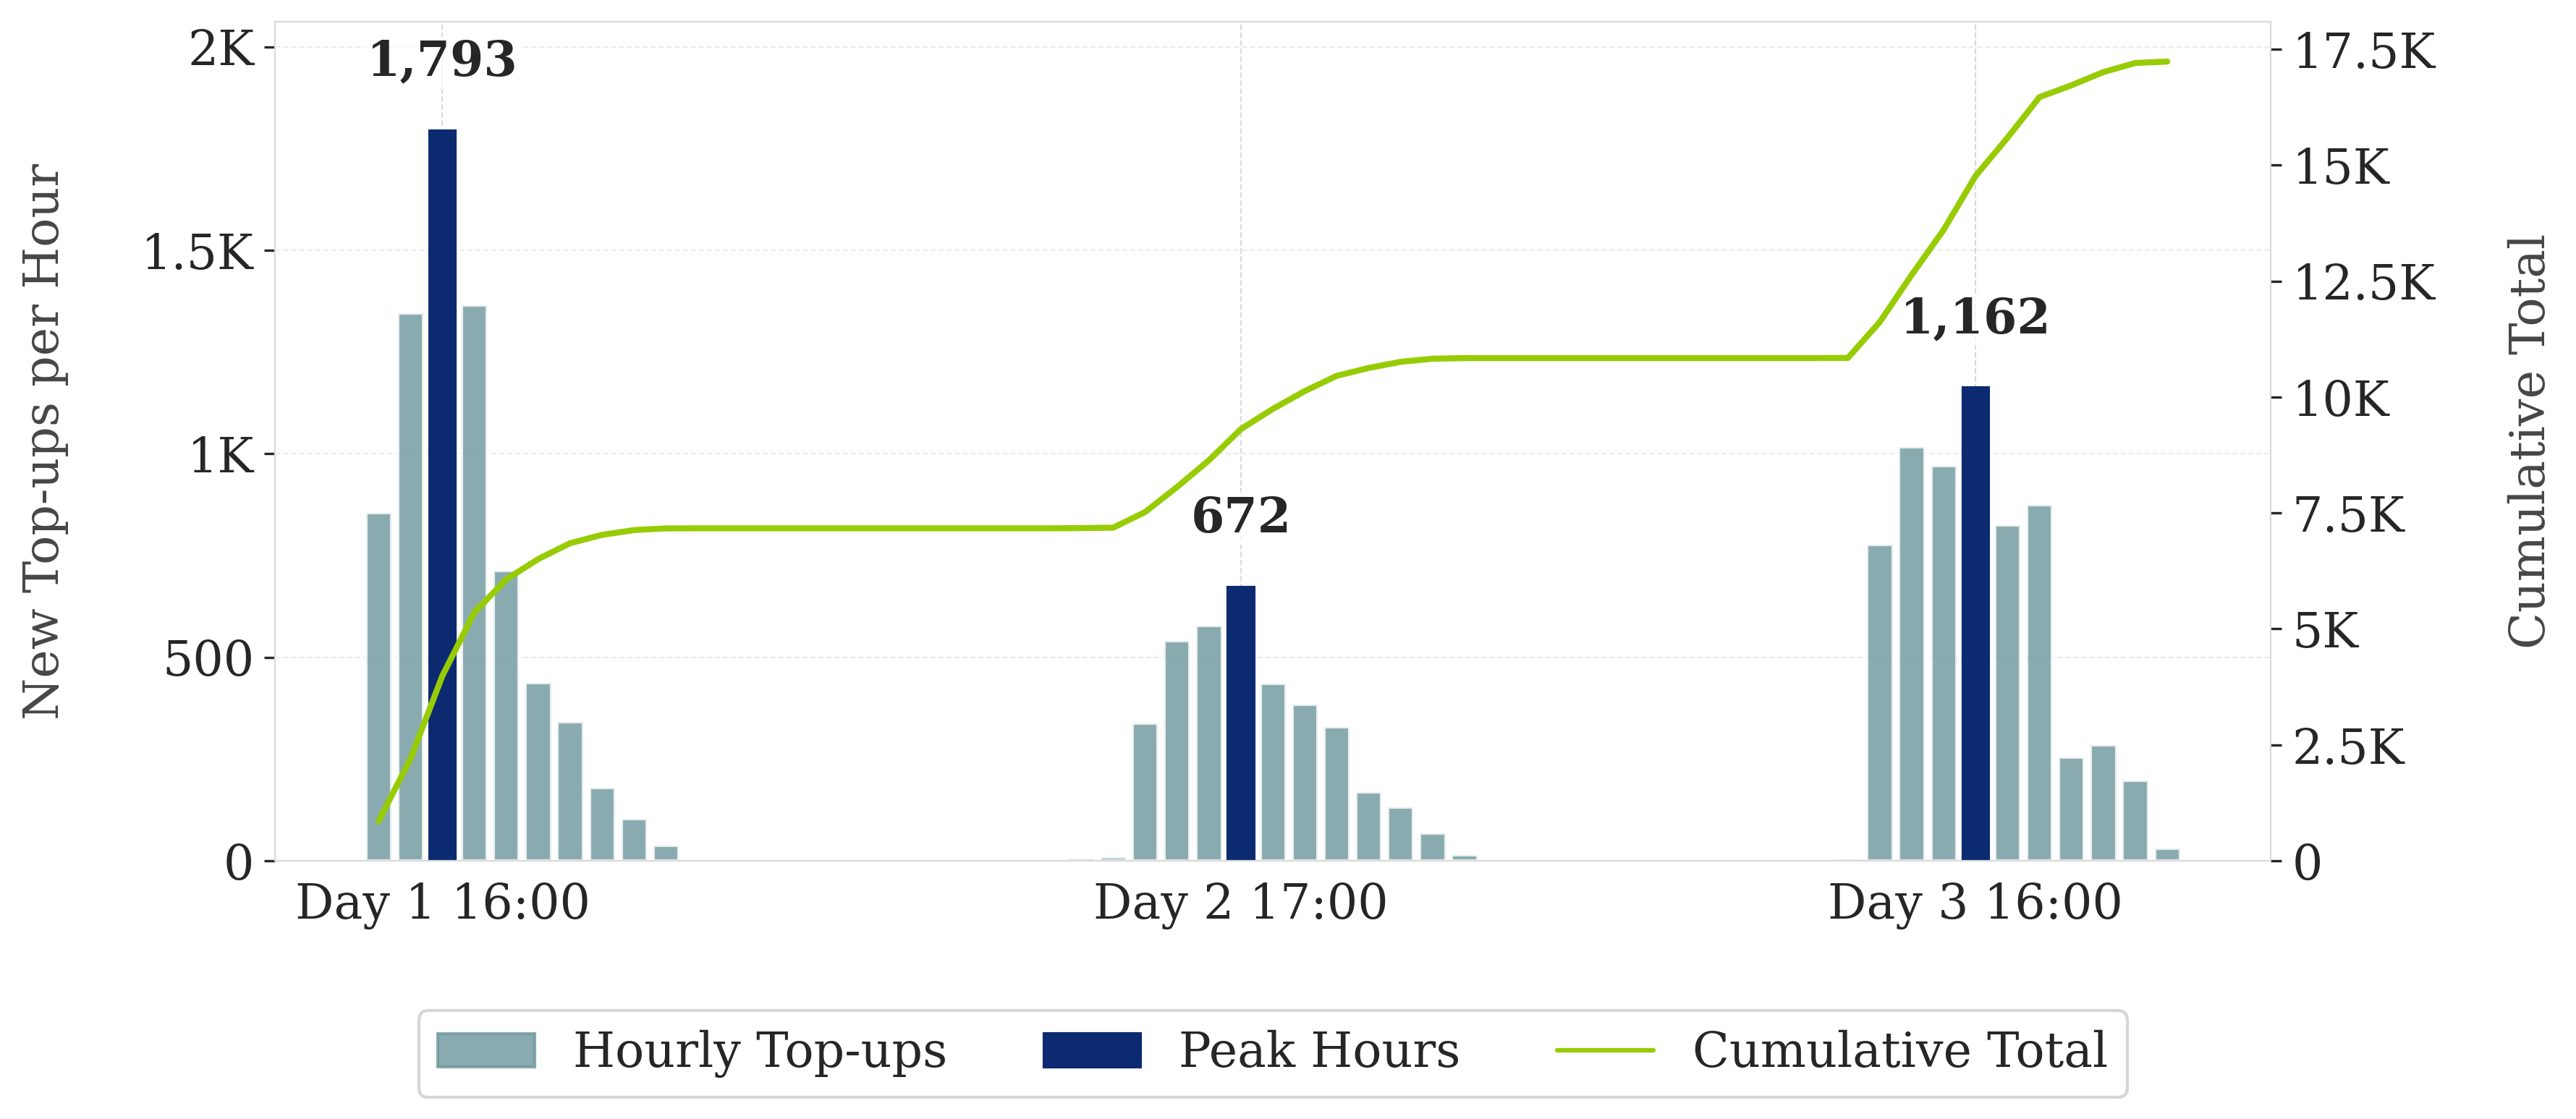

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator

# Set up the figure with specific size
df = topups.copy()
df['hour'] = pd.to_datetime(df['hour'])

plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Set y-axis limits with padding to prevent overflow
max_topups = df['topup_count'].max()
y_max = max_topups * 1.15  # Add 15% padding
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, df['total_topup_count'].max() * 1.05)  # 5% padding for cumulative

# Create bar chart for hourly top-ups
x = mdates.date2num(df['hour'])
width = (x[1] - x[0]) * 0.8

bars = ax1.bar(
	x,
	df['topup_count'],
	width=width,
	color=get_chart_color(2),
	alpha=0.8
)

# Plot cumulative line
line = ax2.plot(
	x,
	df['total_topup_count'],
	color=get_chart_color(3),
	linewidth=2,
	label='Cumulative Total'
)

# Improve grid styling
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax2.grid(axis='y', linestyle='--', alpha=0)

peak_positions = []
peak_times = []

# Find daily peaks and highlight them
for day in pd.date_range('2024-07-04', '2024-07-06'):
	day_data = df[df['hour'].dt.strftime('%Y-%m-%d') == day.strftime('%Y-%m-%d')]
	if len(day_data) > 0:
		peak_hour = day_data.nlargest(1, 'topup_count').iloc[0]
		idx = df.index[df['hour'] == peak_hour['hour']][0]
		bars[idx].set_color(get_chart_color(0))
		bars[idx].set_alpha(1.0)

		peak_positions.append(x[idx])
		peak_times.append(peak_hour['hour'])

		# Improve peak annotations
		ax1.annotate(
			f'{int(peak_hour["topup_count"]):,}',
			xy=(x[idx], peak_hour['topup_count']),
			xytext=(0, 15),  # Increased vertical offset
			textcoords='offset points',
			ha='center',
			va='bottom',
			fontweight='bold',
			fontsize=16,
			bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)
		)

# Format axes with improved spacing
ax1.set_ylabel('New Top-ups per Hour', fontsize=16, labelpad=24, color=get_chart_color('text'))
ax2.set_ylabel('Cumulative Total', fontsize=16, labelpad=24, color=get_chart_color('text'))
ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)

# Format x-axis
ax1.set_xticks(peak_positions)
ax1.xaxis.set_major_formatter(
	plt.FuncFormatter(
		lambda x, p: format_event_datetime(mdates.num2date(x))
	)
)
plt.xticks(rotation=45, ha='right')

# Format y-axis numbers
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number_short(x)))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number_short(x)))

# Improved legend - moved below the chart
legend_elements = [
	plt.Rectangle((0, 0), 1, 1, color=get_chart_color(2), alpha=0.8, label='Hourly Top-ups'),
	plt.Rectangle((0, 0), 1, 1, color=get_chart_color(0), label='Peak Hours'),
	plt.Line2D([0], [0], color=get_chart_color(3), label='Cumulative Total')
]
ax1.legend(
	handles=legend_elements,
	loc='upper center',
	fontsize=16,
	bbox_to_anchor=(0.5, -0.15),  # Moved below by adjusting y coordinate
	ncol=3
)

# Adjust layout with more bottom padding to accommodate legend
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Added padding at bottom [left, bottom, right, top]

plt.savefig("./thesis/results/rq23-topup-patterns.png", dpi=300, bbox_inches='tight', pad_inches=0.1)